# Classificação de armas por waveform (áudio bruto)

Treinamento com **waveform** (1D) em vez de mel-espectrograma, usando **1D CNN** e **data augmentation** para buscar resultado melhor que o baseline (~62%).  
Dataset: [Gunshot Audio Dataset](https://www.kaggle.com/datasets/emrahaydemr/gunshot-audio-dataset).

## Apresentação do trabalho

Alunos:

- Orlando - 122210927
- Vinícius Ian - 122210392
- Jhonata - 122210145
- Everton Kauan - 122210386
- Gabriel Dantas - 121110669

### Roteiro da apresentação

**Contexto e objetivo**
- Problema: reconhecer a **classe do disparo** a partir do **som**.
- Diferença para a abordagem com mel-espectrograma: aqui treinamos direto no **waveform (sinal 1D)**, sem “transformar em imagem”.
- Meta: buscar desempenho **acima do baseline (~0.62)** e entender vantagens/limitações do áudio bruto.

**Fluxo do notebook (visão rápida)**
1. Carregar paths e rótulos do dataset (pastas por classe).
2. Separar em treino/validação/teste com **estratificação**.
3. Padronizar o áudio: **22.050 Hz**, **2s** → **44.100 amostras**.
4. Aumentar dados (apenas no treino): **ruído** e **time shift**.
5. Treinar uma **CNN 1D**.
6. Avaliar com relatório por classe e **matriz de confusão**.


## Imports e configuração

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dense, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

# Parâmetros de áudio (mesmos do notebook principal)
SAMPLE_RATE = 22050
DURATION = 2.0
SAMPLES_FIXOS = int(SAMPLE_RATE * DURATION)  # 44100

2026-02-27 10:55:52.234371: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-27 10:55:52.275276: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-27 10:55:54.514994: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Carregar lista de arquivos e rótulos

In [2]:
def criar_dataframe_arquivos(diretorio_base):
    lista_arquivos = []
    for label in os.listdir(diretorio_base):
        path_classe = os.path.join(diretorio_base, label)
        if os.path.isdir(path_classe):
            for nome_arquivo in os.listdir(path_classe):
                if nome_arquivo.lower().endswith(('.wav', '.mp3')):
                    path_completo = os.path.join(path_classe, nome_arquivo)
                    lista_arquivos.append({'filepath': path_completo, 'label': label})
    return pd.DataFrame(lista_arquivos)

path = Path("data")
df_audios = criar_dataframe_arquivos(path)
X = df_audios['filepath'].values
y = df_audios['label'].values
print(f"Total: {len(X)} amostras, {len(np.unique(y))} classes")

Total: 751 amostras, 8 classes


## Split treino / validação / teste

15,00 % teste
15,00 % validação
70,00 % treino


### Justificativa do split (Treino / Validação / Teste)

- Usamos uma separação típica:
  - **70% treino**, **15% validação**, **15% teste**
- `stratify=y` garante que a proporção das classes se mantenha nas três partições.
- Interpretação na apresentação:
  - **Treino** ajusta os pesos
  - **Validação** controla overfitting e ajusta hiperparâmetros
  - **Teste** mede desempenho final em dados **nunca vistos**


In [3]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.176, random_state=42, stratify=y_train_val
)
print(f"Treino: {len(X_train)}, Val: {len(X_val)}, Teste: {len(X_test)}")

Treino: 525, Val: 113, Teste: 113


## Carregar waveform (com data augmentation no treino)

Cada áudio vira um vetor de tamanho fixo `SAMPLES_FIXOS`. No treino aplicamos **ruído gaussiano** e **deslocamento no tempo** para melhor generalização.

In [4]:
def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_y = y + noise_factor * noise
    return augmented_y

def time_shift(y, shift_max=0.2):
    shift = np.random.randint(int(len(y) * shift_max))
    return np.roll(y, shift)

def carregar_waveform(filepath, augment=False, choice=None):
    # 1. Carrega o áudio original
    y, sr = librosa.load(filepath, sr=SAMPLE_RATE, mono=True, duration=DURATION)
    
    # 2. Aplica Augmentation 
    if augment:
        if choice == "noise":
            y = add_noise(y)
        elif choice == "shift":
            y = time_shift(y)

    # 3. Garante o tamanho exato (Padding ou Corte)
    if len(y) < SAMPLES_FIXOS:
        y = librosa.util.fix_length(y, size=SAMPLES_FIXOS)
    else:
        y = y[:SAMPLES_FIXOS]
        
    # 4. Normalização (Essencial para waveforms treinarem bem)
    y = (y - np.mean(y)) / (np.std(y) + 1e-8)
    
    return y.astype(np.float32)

In [5]:
le = LabelEncoder()
# Criamos as versões numéricas originais
y_train_encoded = le.fit_transform(y_train)
y_val_num = le.transform(y_val)
y_test_num = le.transform(y_test)
nomes_classes = le.classes_
NUM_CLASSES = len(nomes_classes)

# --- 1. GERAÇÃO DOS DADOS DE TREINO (Aumentados 3x) ---
print("Carregando waveforms de TREINO (Originais)...")
X_train_wav_orig = [carregar_waveform(f, augment=False) for f in tqdm(X_train)]

print("Carregando waveforms de TREINO (Com Ruído)...")
X_train_wav_noise = [carregar_waveform(f, augment=True, choice="noise") for f in tqdm(X_train)]

print("Carregando waveforms de TREINO (Com Shift)...")
X_train_wav_shift = [carregar_waveform(f, augment=True, choice="shift") for f in tqdm(X_train)]

# Concatena as listas e converte para Array Numpy
X_train_wav_final = np.array(X_train_wav_orig + X_train_wav_noise + X_train_wav_shift)

# --- 2. GERAÇÃO DE VALIDAÇÃO E TESTE (Originais) ---
print("Carregando waveforms de VALIDAÇÃO...")
X_val_wav_final = np.array([carregar_waveform(f) for f in tqdm(X_val)])

print("Carregando waveforms de TESTE...")
X_test_wav_final = np.array([carregar_waveform(f) for f in tqdm(X_test)])

# --- 3. ADICIONAR DIMENSÃO DE CANAL (N, SAMPLES, 1) ---
X_train_wav_final = X_train_wav_final[..., np.newaxis]
X_val_wav_final = X_val_wav_final[..., np.newaxis]
X_test_wav_final = X_test_wav_final[..., np.newaxis]

# --- 4. TRATAMENTO DOS RÓTULOS (Triplicação para bater com o Treino) ---
y_train_wav_final = np.concatenate([y_train_encoded, y_train_encoded, y_train_encoded])

# --- 5. SHUFFLE (Garante que o modelo não aprenda a ordem das transformações) ---
# Usamos random_state=42 para ser idêntico ao que foi feito nos espectrogramas
X_train_wav_final, y_train_wav_final = shuffle(X_train_wav_final, y_train_wav_final, random_state=42)

print("-" * 30)
print(f"Treino Waveform: {X_train_wav_final.shape} | Labels: {y_train_wav_final.shape}")
print(f"Validação Waveform: {X_val_wav_final.shape} | Labels: {y_val_num.shape}")
print("-" * 30)

Carregando waveforms de TREINO (Originais)...


  0%|          | 0/525 [00:00<?, ?it/s]/home/orlandojunior/miniconda3/envs/percepcao/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 525/525 [00:02<00:00, 184.90it/s]


Carregando waveforms de TREINO (Com Ruído)...


100%|██████████| 525/525 [00:01<00:00, 281.18it/s]


Carregando waveforms de TREINO (Com Shift)...


100%|██████████| 525/525 [00:01<00:00, 510.48it/s]


Carregando waveforms de VALIDAÇÃO...


100%|██████████| 113/113 [00:00<00:00, 523.16it/s]


Carregando waveforms de TESTE...


100%|██████████| 113/113 [00:00<00:00, 529.31it/s]


------------------------------
Treino Waveform: (1575, 44100, 1) | Labels: (1575,)
Validação Waveform: (113, 44100, 1) | Labels: (113,)
------------------------------


## Modelo: 1D CNN na waveform

Convoluções 1D com **strides** reduzem o comprimento temporal rapidamente (eficiente). BatchNorm (normaliza afim de treino mais estável) e Dropout (menor overfitting) ajudam a generalizar.

### Explicando a arquitetura (CNN 1D)

- A CNN 1D procura padrões locais no tempo (transientes do disparo e texturas do sinal).
- Blocos convolucionais com **strides** e **pooling** reduzem rapidamente o comprimento temporal → treino mais eficiente.
- `BatchNormalization` acelera e estabiliza o treinamento.
- `GlobalAveragePooling1D` reduz parâmetros e ajuda a generalização.
- Camadas finais:
  - `Dense(128)` com **L2** (regularização) + `Dropout(0.5)`
  - `Dense(NUM_CLASSES, softmax)` produz a probabilidade por classe


In [6]:
model = Sequential([
    Conv1D(64, 80, strides=4, activation='relu', input_shape=(SAMPLES_FIXOS, 1), padding='same'),
    BatchNormalization(),
    MaxPooling1D(4),
    Conv1D(128, 16, strides=2, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(4),
    Conv1D(256, 8, strides=2, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(4),
    Conv1D(256, 4, activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/home/orlandojunior/miniconda3/envs/percepcao/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1772200562.565293    2985 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9274 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 11025, 64)      │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 11025, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2756, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1378, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1378, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 344, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 172, 256)       │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 172, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 43, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 43, 256)        │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 43, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 697,928 (2.66 MB)

 Trainable params: 696,520 (2.66 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Treinamento

### Estratégia de treinamento (o que destacar)

- Função de perda: `sparse_categorical_crossentropy` (rótulos inteiros).
- Otimizador: `Adam`.
- Callbacks usados:
  - **EarlyStopping** (monitorando `val_loss`) para parar quando não há ganho real.
  - **ReduceLROnPlateau** para reduzir a taxa de aprendizado quando a validação estagna.
  - **ModelCheckpoint** salvando o melhor modelo por `val_accuracy`.

In [7]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    min_delta=0.001,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   # Reduz a LR em 5x
    patience=5,   # Se em 5 épocas não melhorar, reduz
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'modelo_waveform_armas.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    verbose=1
)

history = model.fit(
    X_train_wav_final, y_train_wav_final,  # Dados triplicados (1785 amostras)
    validation_data=(X_val_wav_final, y_val_num), # Dados originais (128 amostras)
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, checkpoint, reduce_lr], # Incluído reduce_lr
    verbose=1
)

Epoch 1/100


2026-02-27 10:56:10.080823: I external/local_xla/xla/service/service.cc:163] XLA service 0x72b600014ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-27 10:56:10.080877: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2026-02-27 10:56:10.124866: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-27 10:56:10.400760: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801
2026-02-27 10:56:10.510226: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-27 10:56:10.510301: I e

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3504 - loss: 3.4173

I0000 00:00:1772200575.993604   44736 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4941 - loss: 2.9867

2026-02-27 10:56:21.222618: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-27 10:56:21.631688: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_199', 8 bytes spill stores, 8 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.27434, saving model to modelo_waveform_armas.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.4962 - loss: 2.9796 - val_accuracy: 0.2743 - val_loss: 3.0208 - learning_rate: 0.0010
Epoch 2/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7809 - loss: 1.8426
Epoch 2: val_accuracy did not improve from 0.27434
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7815 - loss: 1.8362 - val_accuracy: 0.2035 - val_loss: 3.5400 - learning_rate: 0.0010
Epoch 3/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8611 - loss: 1.2726
Epoch 3: val_accuracy did not improve from 0.27434
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8614 - loss: 1.2697 - val_accuracy: 0.2212 - val_loss: 3.2817 - learning_rate: 0.0010
Epoch 4/100
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9145 - loss: 0.9041
Epoch 4: val_accuracy improved from 0.27434 to 0.30973, saving model to modelo_waveform_armas.keras
50/50 ━━━━━━━━━━━━━━

## Curvas de treino

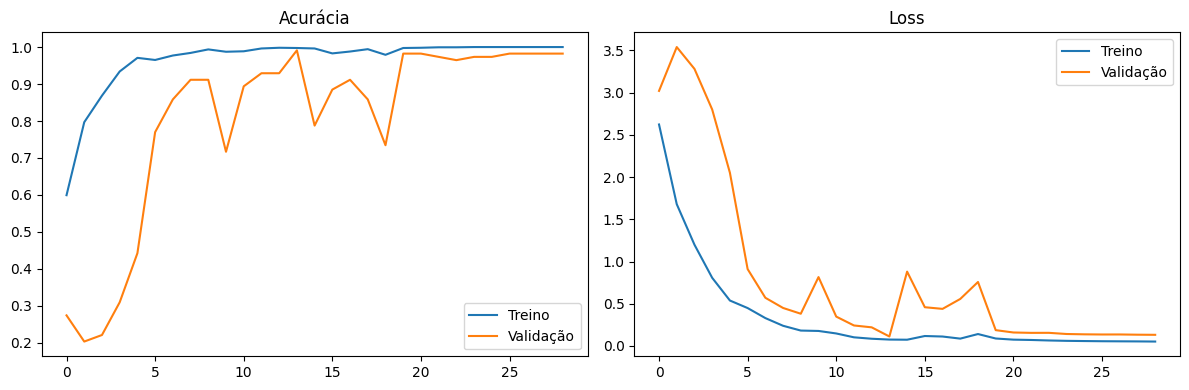

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

### Análise das Curvas de Treinamento

#### Acurácia

A acurácia de treino cresce rapidamente nas primeiras épocas e continua subindo de forma estável, chegando acima de ~90%.

A acurácia de validação também aumenta de maneira significativa, porém com maior oscilação.

A diferença consistente entre treino e validação indica **leve overfitting**: o modelo aprende muito bem o conjunto de treino, mas generaliza com um limite claro no conjunto de validação (algo esperado em bases menores e/ou com classes semelhantes).

#### Loss/Perda

A perda de treino diminui continuamente ao longo das épocas, mostrando convergência e aprendizado consistente.

A perda de validação cai bastante no início, mas apresenta **instabilidade em um ponto do treino** (um pico perceptível por volta de ~14 épocas), e depois volta a reduzir e entra em **platô**.

Nas épocas finais, a validação tende a manter/elevar levemente a perda enquanto o treino continua melhorando, reforçando o cenário de overfitting leve e justificando o uso de **Early Stopping** quando a validação deixa de evoluir.

In [9]:
y_pred_probs = model.predict(X_test_wav_final)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("--- Relatório de Classificação ---\n")
print(classification_report(y_test_num, y_pred_classes, target_names=nomes_classes))
print("\nAcurácia no teste:", np.mean(y_pred_classes == y_test_num))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step
--- Relatório de Classificação ---

                  precision    recall  f1-score   support

           AK-12       1.00      1.00      1.00        15
           AK-47       1.00      1.00      1.00        11
IMI Desert Eagle       0.75      1.00      0.86        15
             M16       1.00      0.60      0.75        15
            M249       1.00      0.87      0.93        15
           MG-42       0.94      1.00      0.97        15
             MP5       0.82      0.93      0.88        15
     Zastava M92       1.00      1.00      1.00        12

        accuracy                           0.92       113
       macro avg       0.94      0.93      0.92       113
    weighted avg       0.94      0.92      0.92       113


Acurácia no teste: 0.9203539823008849


## Interpretação do relatório de classificação (Notebook: waveform + CNN 1D)

### Visão geral

- O modelo atingiu acurácia ~0.92 em 113 amostras, indicando um desempenho bom no geral.

- As médias macro avg (0.94) e weighted avg (0.94) estão muito próximas, o que sugere que o desempenho global não está sendo “enganado” por desbalanceamento forte — porém existe uma classe extremamente problemática que derruba a confiabilidade em casos específicos.

- Destaques por classe (pontos fortes)

    - O modelo tem resultados excelentes para a maioria das classes, por exemplo:

       -  AK-12: 1.00 / 1.00 / 1.00 (perfeito)

       -  Zastava M92: 1.00 / 1.00 / 1.00

       -  MG-42: 0.94 / 1.00 / 0.97

       -  M249: 1.00 / 0.87 / 0.93

       -  AK-47: 1.00 / 1.00 / 1.00

- Além disso, há classes boas/intermediárias:

        IMI Desert Eagle: 0.75 / 1.00 / 0.86 (boa, mas com precisão menor)

        MP5: 0.82 / 0.93 / 0.88 (alta precisão, mas perde recall — ou seja, quando prevê MP5 costuma acertar, mas deixa de identificar muitos casos reais)

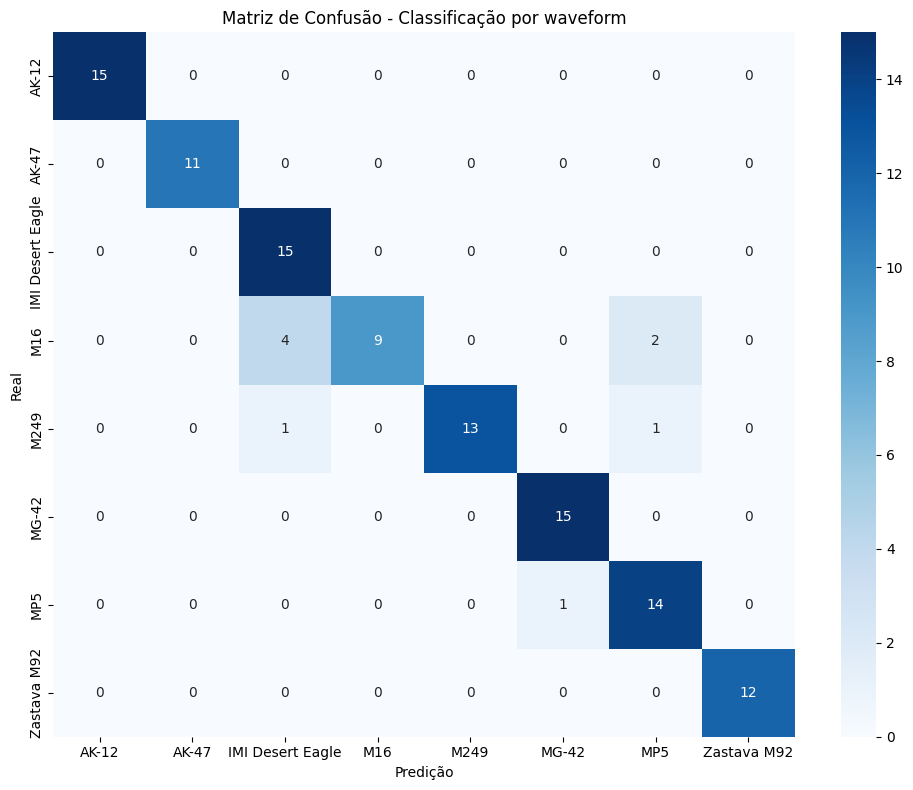

In [2]:
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_test_num, y_pred_classes)
sns.heatmap(cm, xticklabels=nomes_classes, yticklabels=nomes_classes, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predição')
ax.set_ylabel('Real')
ax.set_title('Matriz de Confusão - Classificação por waveform')
plt.tight_layout()
plt.show()

### Leitura da matriz de confusão

A diagonal principal representa os acertos por classe. Já os valores fora da diagonal mostram onde o modelo mais se confunde.

## Conclusão (Notebook waveform)

Neste notebook foi construída uma pipeline completa de classificação de áudio usando waveform (sinal bruto): padronização dos áudios (22.050 Hz, 2s), normalização, data augmentation no treino e treinamento de uma CNN 1D, com avaliação final via relatório de classificação e matriz de confusão.